This code is reproduction of the version 5 of "Dealing with the Inventory Risk" by Gueant, Lehalle and Tapia. 

Indeed the article is not trivial for a newcomer to the market making world, as well as for those who don't have a formal training in formal mathematics. In my case, since I'm far better at programming than in doing math, I decided to reproduce the surfaces in the article after some long time of struggle. 

I didn't know any tutor or professional in this area to help me out, so the reproduction of the article was the only way I found to assert that my understanding is correct. The article's version used as reference here is found in https://arxiv.org/abs/1105.3115

This notebook is divided in two parts. The first one is a reproduction of the standard implementation, and the second one is the implementation of the solution with drift, where I believe there is an error.


Part 1: standard solution

The first plot to be reproduced is the one in page 8:

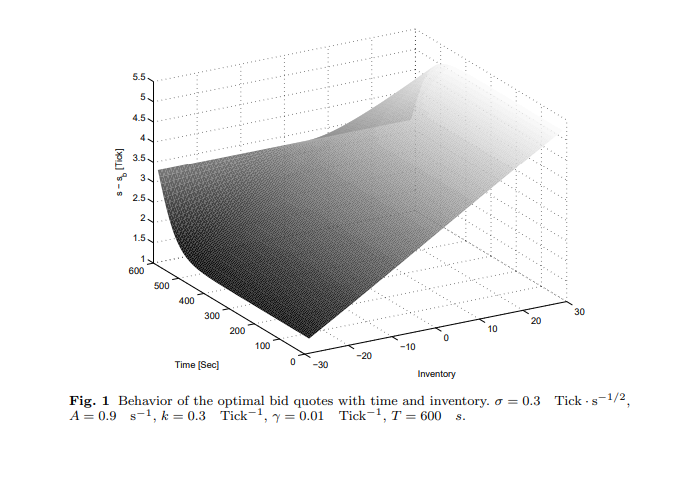

In [116]:
from IPython.display import Image
Image(filename='images/bid_surface.png',width=1000, height=600)

Now, proceeding to the imports and to the variable declarations. I'm using the same ones that can be found in the footnot of figure 1 of course:

In [117]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
from scipy.linalg import expm
import math


max_inventory_Q = 30
min_inventory_Q = -max_inventory_Q

sigma = 0.3
A = 0.9
kappa = 0.3
gamma =  0.01
T = 600 # Terminal Time
dt = 1

To get to the surface, one must implement the theorem 1.

Image(filename='images/theorem_1.png',width=800, height=400)

And the "Value v of q at give time t" component can be obtained through proposition 2:

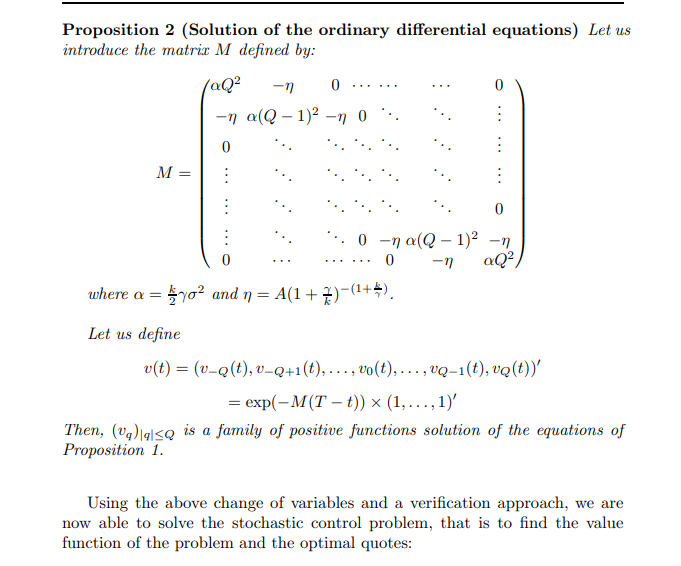

In [118]:
Image(filename='images/proposition_2.png',width=800, height=600)

So code wide one must first implement matrix M, to then calculate the respective values functions of the portfolio with inventory q at time t.

First step is to construct a matrix with the elements. 

Iterations reference is about the size of the matrix; alpha and nill are very straight forward because one just needs to calculate:

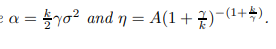

In [119]:
Image(filename='images/alpha_and_nill.png',width=800, height=400)

In [120]:
iterations_reference = 2 * max_inventory_Q + 1
## ALPHA, Nill
alpha = (kappa / 2) * gamma * sigma ** 2
nill  = A * (1 + gamma / kappa) ** ( - (1 + kappa / gamma) )

Constructing matrix M. Code-wise and to make it simpler, I'll first place the elements to the each rown, to then stack the rows in the end to create a numpy matrix.

It's a bit tricky to see, but the "1" in "alpha * (Q - 1) ** 2" should be offset as 

In [121]:
matrix_M = []
first_row = []
last_row = []
list_middle_rows = []

for i in range(min_inventory_Q, max_inventory_Q + 1, 1):

    # Populating first row
    if i == min_inventory_Q: 
        first_row.append(alpha * max_inventory_Q ** 2)
        first_row.append(-nill)
        first_row.extend([0 for j in range(iterations_reference - 2)])

    # Populating last row
    elif i == max_inventory_Q:
        last_row.extend([0 for j in range(iterations_reference - 2)])
        last_row.append(-nill)
        last_row.append(alpha * max_inventory_Q ** 2)

    # Populating middle rows
    else:
        middle_row = []
        if i < 0:
            middle_row.extend([-nill, alpha * ( max_inventory_Q - (max_inventory_Q - abs(i) ) ) ** 2, -nill])
            middle_row.extend([0 for j in range(iterations_reference - 3)])

            if i > -max_inventory_Q + 1:
                for j in range(0, max_inventory_Q + i - 1, 1):
                    middle_row.insert(0,middle_row.pop())

        if i == 0:
            middle_row = [0 for j in range(iterations_reference)]
            middle_row[max_inventory_Q + 1] = -nill
            middle_row[max_inventory_Q - 1] = -nill
            assert len(middle_row) == iterations_reference

        if i > 0:
            middle_row.extend([0 for j in range(iterations_reference - 3)])
            middle_row.extend([-nill, alpha * ( max_inventory_Q - (max_inventory_Q - abs(i)) ) ** 2, -nill])

            for j in range(0,  max_inventory_Q - i - 1, 1):
                middle_row.append(middle_row.pop(0))

        assert len(middle_row) == iterations_reference
        list_middle_rows.append(middle_row)

matrix_M.append(first_row)
matrix_M.extend(list_middle_rows)
matrix_M.append(last_row)

assert len(first_row) == iterations_reference
assert len(last_row) == iterations_reference

# Converting to numpy array
matrix_M = np.matrix(matrix_M)

pprint(matrix_M)

matrix([[ 0.1215    , -0.32567836,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [-0.32567836,  0.113535  , -0.32567836, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        , -0.32567836,  0.10584   , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  0.10584   ,
         -0.32567836,  0.        ],
        [ 0.        ,  0.        ,  0.        , ..., -0.32567836,
          0.113535  , -0.32567836],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         -0.32567836,  0.1215    ]])


We have the matrix M, and we can calculate "v of q at time t" 

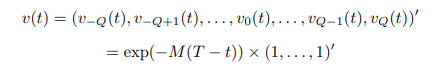

In [122]:
Image(filename='images/v_of_t.png',width=800, height=600)

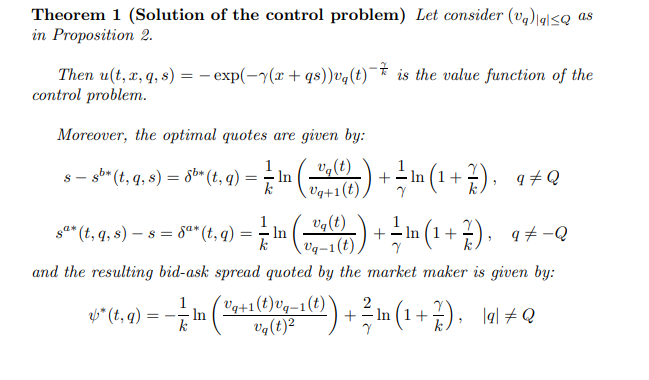

In [123]:
Image(filename='images/theorem_1.png',width=800, height=600)

Calculating the bid surface. One can also uncomment the ask stuff to get to the ask surface.

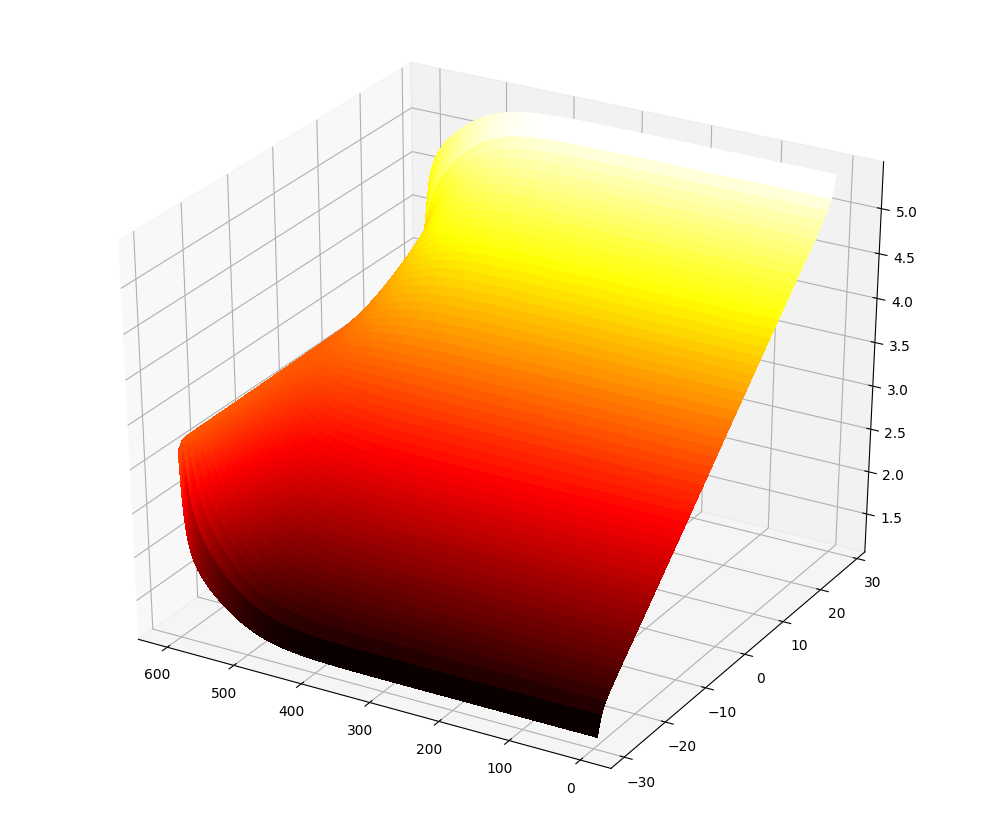

In [124]:
# to store the quotes at each time stap

list_evolution_bid = []
#list_evolution_ask = [] 


for t in range(0, T  , 1):
    
    dict_bid = {}
    # dict_ask = {}
    
    container = -matrix_M * (T - t)

    v_of_t = expm(container)
    v_of_t  = np.sum(np.multiply(v_of_t, np.ones(v_of_t.shape[0])), axis=1)

    # for each q in -Q .. Q apply the quotes theorem
    # variable "pseudo_q" is used because otherwise, the incorrect index of the v_of_t will be selected 
    # (negative q would go for the last element of v_of_t instead of the first one. 
    for pseudo_q in range(0, iterations_reference -1, 1):        
        q = pseudo_q - max_inventory_Q # real q
        
        bid = (1 / kappa) * np.log(v_of_t[pseudo_q] / v_of_t[pseudo_q + 1]) + (1 / gamma) * np.log(1 + gamma / kappa)
        #ask = (1 / kappa) * np.log(v_of_t[q] / v_of_t[q - 1]) + (1 / gamma) * np.log(1 + gamma / kappa)
        
        # Storing in a dict
        dict_bid[q] = bid
        #dict_ask[q - max_inventory_Q] = ask

    # Bid quote at max_inventory (q = +Q) is inexistent, as such for ask quote at min_inventory (q = -Q)
    dict_bid[max_inventory_Q] = None
    #dict_ask[min_inventory_Q] = None

    list_evolution_bid.append(list(dict_bid.values())[1:-2])

# Plotting. Some rearrengements must be made to make the surface look just like in article
X = np.arange(1, T+1, 1)
Y = np.arange(min_inventory_Q+1, max_inventory_Q-1 , 1)
X, Y = np.meshgrid(X, Y)

Z = np.array(list_evolution_bid).T
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='hot', linewidth=0, antialiased=False)
ax.invert_xaxis()

# Voilà! :)
fig.set_size_inches(12.5, 10.5, forward=True)
plt.show()

Plotting the image from the article once again so that we don't have to keep scrolling this notebook up and down to be able to make a comparisson.

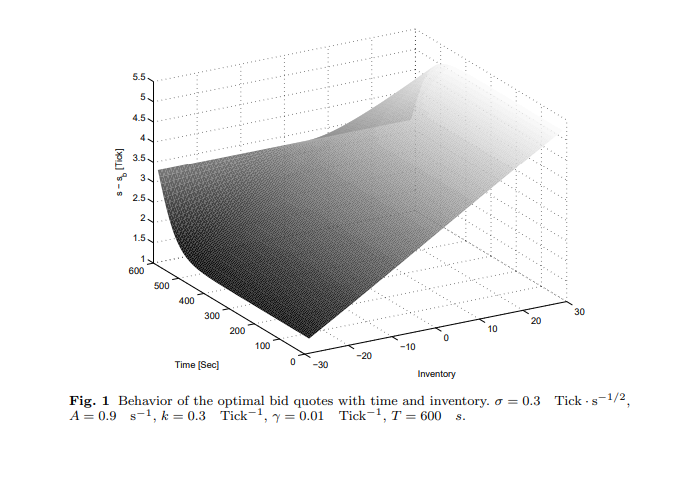

In [44]:
Image(filename='images/bid_surface.png',width=1000, height=600)

A sanity check: both surfaces have quote around 5.3 when q = +Q; bid is around 1.5 when q = -Q. Bid at t = 0 is at ~3.4, independently of q.

Part 2: solution with drift

There is another theorem in the article, it's a solution with a drift component u:

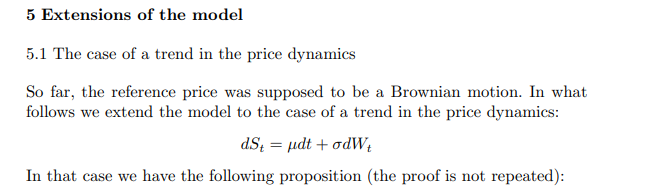

In [125]:
Image(filename='images/declaration_of_extension.png',width=1000, height=600)

My intuition is very simple regarding the drift term. If the market maker things that he price will go up, he should skew the quotes upwards, and the same thinking process for the opposite direction.

The question is how should u be normalized? There are no nummerical simulations in this part of the article, so it took me a bit of time to figure out. In Fodra's and Labadie' paper https://arxiv.org/pdf/1206.4810.pdf on page 25:

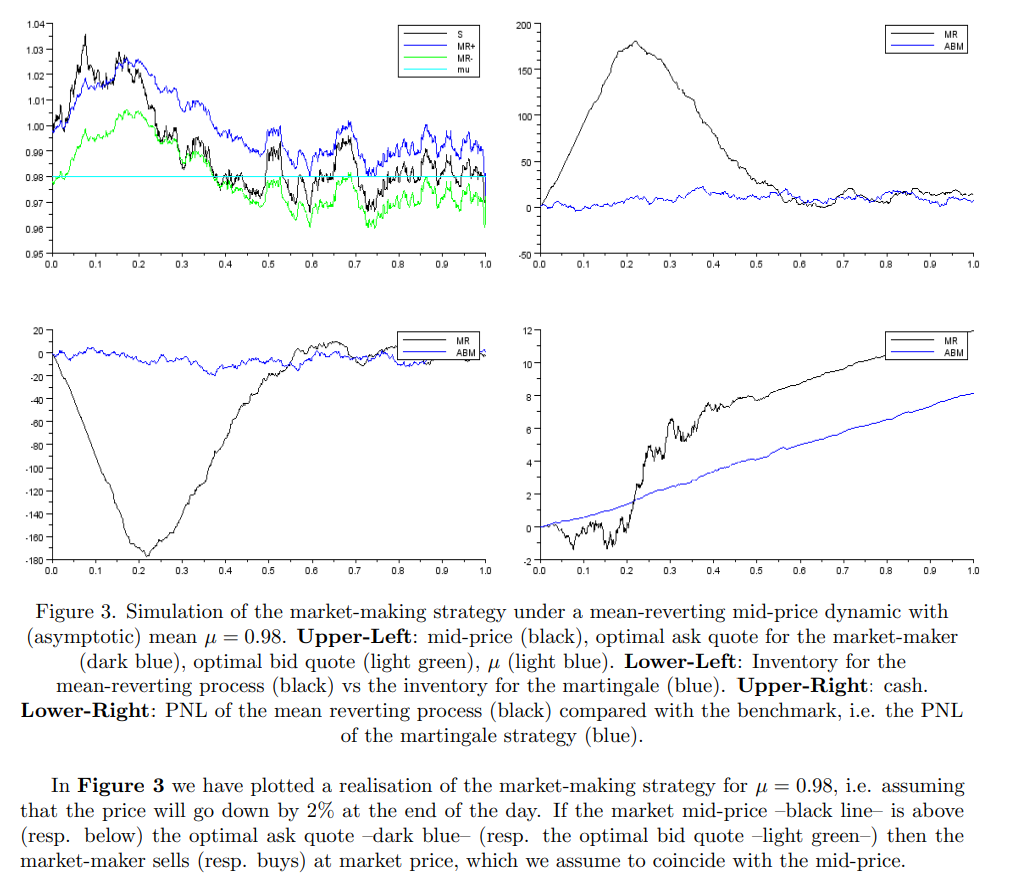

In [126]:
Image(filename='images/drift_definition.png',width=1000, height=600)

So it means that u should be positive and that if it is higher than 1, means that the market maker thinks that the market will go up, and if it is less than 1, that the market will go down.

Now going back to "Dealing with the inventory risk". The is a beta term in proposition 4 tha encapsulates the drift term:

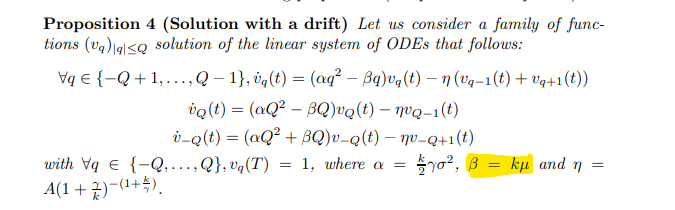

In [127]:
Image(filename='images/declaration_of_beta.png',width=1000, height=600)

And the beta term is added to the matrix M:

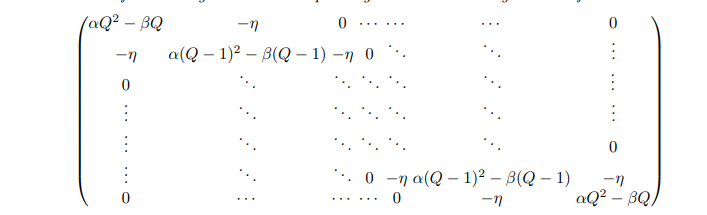

In [128]:
Image(filename='images/matrix_m_with_beta.png',width=1000, height=600)

Let's recalculate the bid surface if the u = 1, the simplest case:

/home/rafaelichow/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in double_scalars
/home/rafaelichow/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:89: RuntimeWarning: invalid value encountered in double_scalars
/home/rafaelichow/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:89: RuntimeWarning: divide by zero encountered in log
/home/rafaelichow/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:88: RuntimeWarning: divide by zero encountered in log
/home/rafaelichow/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:109: UserWarning: Z contains NaN values. This may result in rendering artifacts.


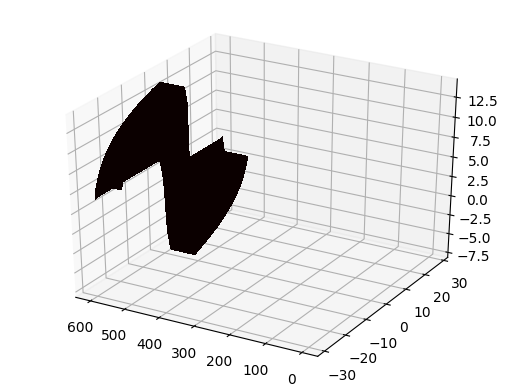

In [129]:

## BASIC VARIABLES
max_inventory_Q = 30
min_inventory_Q = -max_inventory_Q
iterations_reference = 2 * max_inventory_Q + 1
sigma = 0.3
A = 0.9
kappa = 0.3
gamma =  0.01
T = 600 # Terminal Time
dt = 1
u = 1.0

## ALPHA, Nill
alpha = kappa / 2 * gamma * (sigma ** 2)
beta = kappa * u
nill  = A * (1 + gamma / kappa) ** - (1 + kappa / gamma)


matrix_M = []
first_row = []
last_row = []
list_middle_rows = []

for i in range(min_inventory_Q, max_inventory_Q + 1, 1):

    # Populating first row
    if i == min_inventory_Q: 
        first_row.append(alpha * max_inventory_Q ** 2 - beta * max_inventory_Q)
        first_row.append(-nill)
        first_row.extend([0 for j in range(iterations_reference - 2)])

    # Populating last row
    elif i == max_inventory_Q:
        last_row.extend([0 for j in range(iterations_reference - 2)])
        last_row.append(-nill)
        last_row.append(alpha * max_inventory_Q ** 2 - beta * max_inventory_Q)

    # Populating middle rows
    else:
        middle_row = []
        if i < 0:
            middle_row.extend([-nill, alpha * ( max_inventory_Q - (max_inventory_Q - abs(i)) ) ** 2 - beta * ( max_inventory_Q - (max_inventory_Q - abs(i)) ), -nill])
            middle_row.extend([0 for j in range(iterations_reference - 3)])

            if i > -max_inventory_Q + 1:
                for j in range(0, max_inventory_Q + i - 1, 1):
                    middle_row.insert(0,middle_row.pop())

        if i == 0:
            middle_row = [0 for j in range(iterations_reference)]
            middle_row[max_inventory_Q + 1] = -nill
            middle_row[max_inventory_Q - 1] = -nill
            assert len(middle_row) == iterations_reference

        if i > 0:
            middle_row.extend([0 for j in range(iterations_reference - 3)])
            middle_row.extend([-nill, alpha * ( max_inventory_Q - (max_inventory_Q - abs(i)) ) ** 2 - beta * ( max_inventory_Q - (max_inventory_Q - abs(i)) ), -nill])

            for j in range(0,  max_inventory_Q - i - 1, 1):
                middle_row.append(middle_row.pop(0))

        assert len(middle_row) == iterations_reference
        list_middle_rows.append(middle_row)

matrix_M.append(first_row)
matrix_M.extend(list_middle_rows)
matrix_M.append(last_row)

assert len(first_row) == iterations_reference
assert len(last_row) == iterations_reference

# Converting to numpy array
matrix_M = np.matrix(matrix_M)

# Simulating negative inventory
list_evolution_bid = []
list_evolution_ask = []
for t in range(0, T  , 1):
    dict_bid = {}
    dict_ask = {}
    list_bid_at_t = []
    container = -matrix_M * (T - t)

    v_of_t = expm(container)
    v_of_t  = np.sum(np.multiply(v_of_t, np.ones(v_of_t.shape[0])), axis=1)

    for q in range(0, iterations_reference -1, 1):
        bid = (1 / kappa) * np.log(v_of_t[q] / v_of_t[q + 1]) + (1 / gamma) * np.log(1 + gamma / kappa)
        ask = (1 / kappa) * np.log(v_of_t[q] / v_of_t[q - 1]) + (1 / gamma) * np.log(1 + gamma / kappa)
        dict_ask[q - max_inventory_Q] = ask
        dict_bid[q - max_inventory_Q] = bid

    dict_bid[max_inventory_Q] = None
    dict_ask[min_inventory_Q] = None
    dict_ask[max_inventory_Q] = dict_bid[min_inventory_Q]

    list_evolution_bid.append(list(dict_bid.values())[1:-2])

# Plotting 
X = np.arange(1, T+1, 1)
Y = np.arange(min_inventory_Q+1, max_inventory_Q-1 , 1)
X, Y = np.meshgrid(X, Y)

Z = np.array(list_evolution_bid).T

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='hot', linewidth=0, antialiased=False)
ax.invert_xaxis()

plt.show()

The plot makes no sense. However, if I force change "beta = k * u" to "beta = -k * u", thus making beta positive in the matrix, the we have this:

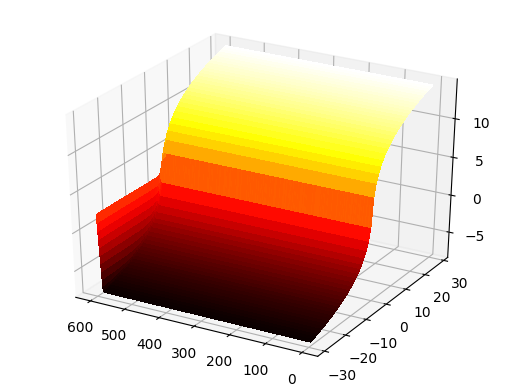

In [162]:

## BASIC VARIABLES
max_inventory_Q = 30
min_inventory_Q = -max_inventory_Q
iterations_reference = 2 * max_inventory_Q + 1
sigma = 0.3
A = 0.9
kappa = 0.3
gamma =  0.01
T = 600
dt = 1


def make_plot(min_inventory_Q, max_inventory_Q, iterations_reference, sigma, A, kappa, gamma, T, dt, u):
    ## ALPHA, Nill
    alpha = kappa / 2 * gamma * (sigma ** 2)
    beta = -kappa * u
    nill  = A * (1 + gamma / kappa) ** - (1 + kappa / gamma)


    matrix_M = []
    first_row = []
    last_row = []
    list_middle_rows = []

    for i in range(min_inventory_Q, max_inventory_Q + 1, 1):

        # Populating first row
        if i == min_inventory_Q: 
            first_row.append(alpha * max_inventory_Q ** 2 - beta * max_inventory_Q)
            first_row.append(-nill)
            first_row.extend([0 for j in range(iterations_reference - 2)])

        # Populating last row
        elif i == max_inventory_Q:
            last_row.extend([0 for j in range(iterations_reference - 2)])
            last_row.append(-nill)
            last_row.append(alpha * max_inventory_Q ** 2 - beta * max_inventory_Q)

        # Populating middle rows
        else:
            middle_row = []
            if i < 0:
                middle_row.extend([-nill, alpha * ( max_inventory_Q - (max_inventory_Q - abs(i)) ) ** 2 - beta * ( max_inventory_Q - (max_inventory_Q - abs(i)) ), -nill])
                middle_row.extend([0 for j in range(iterations_reference - 3)])

                if i > -max_inventory_Q + 1:
                    for j in range(0, max_inventory_Q + i - 1, 1):
                        middle_row.insert(0,middle_row.pop())

            if i == 0:
                middle_row = [0 for j in range(iterations_reference)]
                middle_row[max_inventory_Q + 1] = -nill
                middle_row[max_inventory_Q - 1] = -nill
                assert len(middle_row) == iterations_reference

            if i > 0:
                middle_row.extend([0 for j in range(iterations_reference - 3)])
                middle_row.extend([-nill, alpha * ( max_inventory_Q - (max_inventory_Q - abs(i)) ) ** 2 - beta * ( max_inventory_Q - (max_inventory_Q - abs(i)) ), -nill])

                for j in range(0,  max_inventory_Q - i - 1, 1):
                    middle_row.append(middle_row.pop(0))

            assert len(middle_row) == iterations_reference
            list_middle_rows.append(middle_row)

    matrix_M.append(first_row)
    matrix_M.extend(list_middle_rows)
    matrix_M.append(last_row)

    assert len(first_row) == iterations_reference
    assert len(last_row) == iterations_reference

    # Converting to numpy array
    matrix_M = np.matrix(matrix_M)

    # Simulating negative inventory
    list_evolution_bid = []
    list_evolution_ask = []
    for t in range(0, T  , 1):
        dict_bid = {}
        dict_ask = {}
        list_bid_at_t = []
        container = -matrix_M * (T - t)

        v_of_t = expm(container)
        v_of_t  = np.sum(np.multiply(v_of_t, np.ones(v_of_t.shape[0])), axis=1)

        for q in range(0, iterations_reference -1, 1):
            bid = (1 / kappa) * np.log(v_of_t[q] / v_of_t[q + 1]) + (1 / gamma) * np.log(1 + gamma / kappa)
            ask = (1 / kappa) * np.log(v_of_t[q] / v_of_t[q - 1]) + (1 / gamma) * np.log(1 + gamma / kappa)
            dict_ask[q - max_inventory_Q] = ask
            dict_bid[q - max_inventory_Q] = bid

        dict_bid[max_inventory_Q] = None
        dict_ask[min_inventory_Q] = None
        dict_ask[max_inventory_Q] = dict_bid[min_inventory_Q]

        list_evolution_bid.append(list(dict_bid.values())[1:-2])

    # Plotting 
    X = np.arange(1, T+1, 1)
    Y = np.arange(min_inventory_Q+1, max_inventory_Q-1 , 1)
    X, Y = np.meshgrid(X, Y)

    Z = np.array(list_evolution_bid).T

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='hot', linewidth=0, antialiased=False)
    ax.invert_xaxis()

    plt.show()
    
u = 1.05
make_plot(min_inventory_Q, max_inventory_Q, iterations_reference, sigma, A, kappa, gamma, T, dt, u)

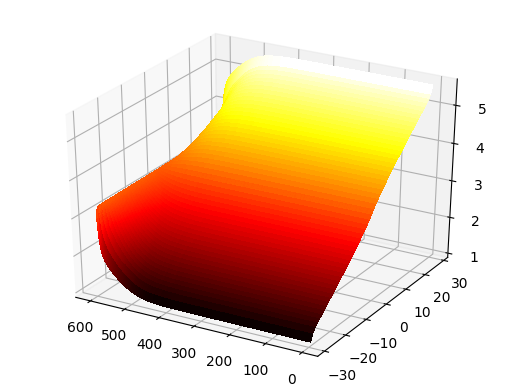

In [161]:
u = 0.95
make_plot(min_inventory_Q, max_inventory_Q, iterations_reference, sigma, A, kappa, gamma, T, dt, u)

which is more aligned with the standard solution, though these are some points:

 - In the case where u = 1.05 under assymptotic behaviour, looking at q = -30, we have bid ~= -5, meaning we are sending market orders. It maybe makes sense to send market orders on the bid side, after all the price is expected to go up.
 - in the case where u = 0.95 under assymptotic behaviour, looking at q = -30, we have bid ~= +1.2 meaning we are placing limit orders. The price is expected to go down and the we are not sending market order on the bid side. However, I was expecting for the bid quote to be higher than the one from the standard solution (here we have ~1.2 and in the stardard solution is ~1.5)
 
 